# Introduction
train and test data are measured with same roll resistance (lever position 3) and wheel pressure.


# Analyze
Question: Which features and model is good enough to be predict virtual power?

_Train data (app data):
* X of app data set -> cadence
* Y -> velocity

## Pre processing


In [7]:
import pandas as pd

from src.tcx import Tcx, COLUMN_NAME_SPEED, COLUMN_NAME_WATTS, COLUMN_NAME_CADENCE, COLUMN_NAME_EXT_SPEED
from src.test_data import TrainDataSet
from src.validation.regression import validate_lin_reg

tcx_app: Tcx = Tcx.read_tcx(file_path='test/tcx/cadence_1612535177298-gear7.tcx')
tcx_tacx: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')
tcx_tacx_gear20: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')

# generate test data
dts_tacx: TrainDataSet = TrainDataSet(tcx_tacx)
dts_app: TrainDataSet = TrainDataSet(tcx_app)

def print_stats(df: pd.DataFrame):
    print(df.assign(speed_bins=lambda x: x[COLUMN_NAME_SPEED].apply(lambda x : int(x)))
          .groupby(by=['speed_bins'])[COLUMN_NAME_WATTS].describe())

    print(df.assign(cadence_bins=lambda x: x[COLUMN_NAME_CADENCE].apply(lambda x : int(x)))
              .groupby(by=['cadence_bins'])[COLUMN_NAME_WATTS].describe())
    #print(df[['Speed', 'Cadence', 'Ext.Watts', 'DistanceMeters', 'DistanceMeters-delta', 'Ext.Speed', 'Time', 'Time-delta']].head(100))
    # print(df[[COLUMN_NAME_SPEED]].describe())

print_stats(dts_app.get_dataframe())
print_stats(dts_tacx.get_dataframe())

            count  mean  std  min  25%  50%  75%  max
speed_bins                                           
17            3.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
18            8.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
19            8.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
20            8.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
21           12.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
22            8.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
23           16.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
24           22.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
25           33.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
26           23.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
27           16.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
28           18.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
29            7.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
30            5.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
              count  mean  std  min  25%  50%  75%  max
cadence_bins                                           
40              1.0   0.

## Linear regression
To find out we create a linear model from the tacx data with differetn features and calculate a score for each tacx cadence value to see whether the model predicts the velocity good enough.

### Cadence
_X_ = [cadence], _y_ = power

=== Speed -> Power ===
Shape X_train/X_test: (89, 1)/(358, 1)
Error R²: 0.78
MSE error (mean squared error / variance): 74.91
sqrt(MSE) (standard deviation): 8.65
Max error: 53.088423877394405
Cross validation: [0.76861522 0.77825673 0.81095016 0.82239426 0.72601798]
Shape X_train/X_test: (89, 1)/(358, 1)
Error R²: 0.78
MSE error (mean squared error / variance): 74.94
sqrt(MSE) (standard deviation): 8.66
Max error: 52.95427994985852
Cross validation: [0.76877872 0.77805532 0.81083059 0.82239738 0.72623107]
=== Cadence -> Power ===
Shape X_train/X_test: (357, 1)/(90, 1)
Error R²: 1.00
MSE error (mean squared error / variance): 1.06
sqrt(MSE) (standard deviation): 1.03
Max error: 2.8912017526499483
Cross validation: [0.99506023 0.99816251 0.9957887  0.99589043 0.99734035]
=== [Cadence, speed] -> Power ===
Shape X_train/X_test: (357, 2)/(90, 2)
Error R²: 1.00
MSE error (mean squared error / variance): 1.05
sqrt(MSE) (standard deviation): 1.03
Max error: 2.8459865106185873
Cross validation

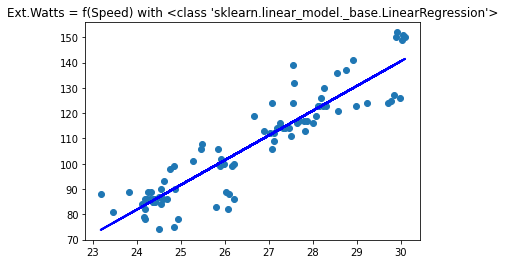

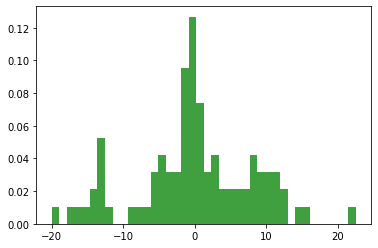

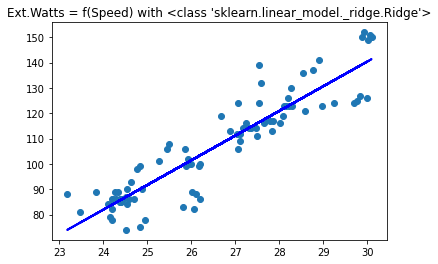

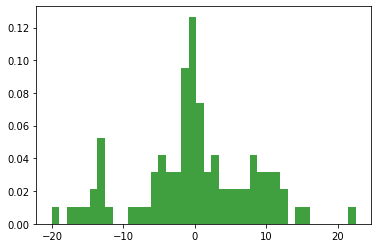

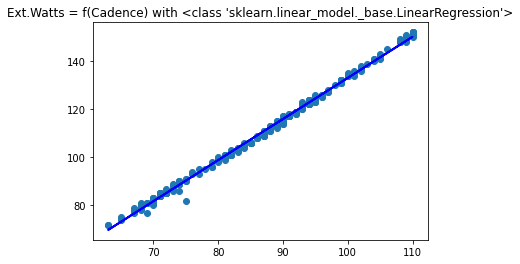

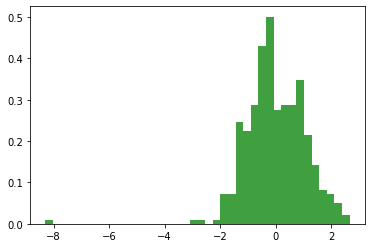

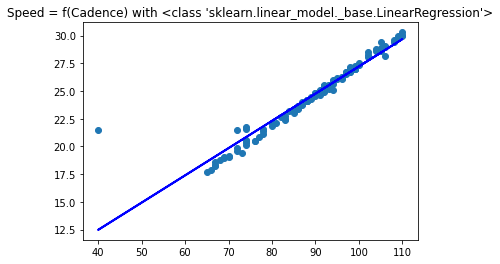

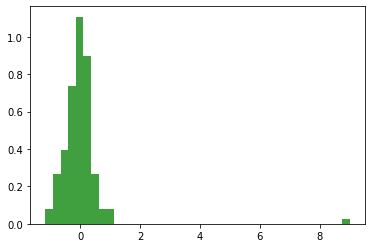

In [8]:
from math import sqrt
from functools import reduce

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import max_error, mean_squared_error
from sklearn.linear_model._base import LinearModel

import matplotlib.pyplot as plt


def plot(estimator: LinearModel, X_train: pd.DataFrame, y_train: pd.Series) -> None:
    # Plot X_train -> y_train
    y_predicted = estimator.predict(X_train)
    plt.scatter(X_train, y_train,  cmap='blue')
    plt.plot(X_train, y_predicted, color='blue', linewidth=2)
    plt.title("{} = f({}) with {}".format(y_train.name, reduce(lambda l, r: "{}, {}".format(l, r), X_train.columns), estimator.__class__))
    plt.xticks()
    plt.yticks()
    plt.show()

    # Plot histogram of absolute error of |y_test - y_predicted|
    plt.hist(y_train - y_predicted, 40, density=True, facecolor='g', alpha=0.75)
    plt.show()
    #plt.close()


random_state = 2
print("=== Speed -> Power ===")
X, y = dts_tacx.speed_to_power()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=random_state)
estimator = LinearRegression()
validate_lin_reg(X_train, y_train, X_test, y_test, estimator)
plot(estimator, X_train, y_train)

estimator = Ridge(alpha=1.0)
validate_lin_reg(X_train, y_train, X_test, y_test, estimator)
plot(estimator, X_train, y_train)

print("=== Cadence -> Power ===")
X, y = dts_tacx.cadence_to_power()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)
estimator = LinearRegression()
validate_lin_reg(X_train, y_train, X_test, y_test, estimator)
plot(estimator, X_train, y_train)

print("=== [Cadence, speed] -> Power ===")
X, y = dts_tacx.cadence_speed_to_power()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)
estimator = LinearRegression()
validate_lin_reg(X_train, y_train, X_test, y_test, estimator)

# plot(estimator, X_train, y_train)

print("=== Cadence -> speed ===")
X, y = dts_app.cadence_to_speed()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)
estimator = LinearRegression()
validate_lin_reg(X_train, y_train, X_test, y_test, estimator)
plot(estimator, X_train, y_train)